# Aerosol field CESM2 

This notebook contains plots of SO4, O3 and AOD in the CESM2 SAI experiment.

Intermediate data is stored in figdata/.

To edit figures only, run the next cell (imports) and continue to section "Plotting"

In [1]:
import glob
import os
import json
from datetime import timedelta
import dask.bag
from dask.distributed import Client
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
from numba import float32, float64, guvectorize
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
%matplotlib inline

In [2]:
# CAM output files
FILES = {
    'control': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI2020': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01/atm/hist/*.h0.*.nc"))[0:300] # 2020-2044
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # 2045-2099
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")), # 2100-2130
    'SAI2080': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

# CAM stratospheric forcing files
STFILES = {
    'SAI20': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_CAMfeedback-2100.nc',
    'SAI20E': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2150_SSP585_CAMfeedback-2131.nc',
    'SAI2080': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2150_SSP585_CAMfeedback.nc',
}


# WACCM output files
WACFILES = {
    'control': ['/home/jasperdj/simone/CMIP6/so4/mmrso4_AERmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
        '/home/jasperdj/simone/CMIP6/o3/o3_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
        '/home/jasperdj/simone/CMIP6/aod/od550so4_AERmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'],
    'SAI2020': ['/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.AODVISstdn.201901-206812.nc',
        '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.AODVISstdn.206901-210012.nc',
        '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.PS.201901-206812.nc',
        '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.PS.206901-210012.nc']
        + sorted(glob.glob('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0zm.so4_a?.*.nc')) 
        + sorted(glob.glob('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0zm.O3.*.nc'))
}

In [3]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)

In [4]:
@guvectorize(
    "(float64[:], float64[:], float64[:], float32[:])",
    " (n), (n), (m) -> (m)",
    nopython=True,
)
def interp1d_gu(f, x, xi, out):
    """Interpolate field f(x) to xi in ln(x) coordinates."""
    i, imax, x0, f0 = 0, len(xi), x[0], f[0]
    while xi[i]<x0 and i < imax:
        out[i] = np.nan
        i = i + 1
    for x1,f1 in zip(x[1:], f[1:]):
        while xi[i] <= x1 and i < imax:
            out[i] = (f1-f0)/np.log(x1/x0)*np.log(xi[i]/x0)+f0
            i = i + 1
        x0, f0 = x1, f1
    while i < imax:
        out[i] = np.nan
        i = i + 1

def xr_interp_pres(da, P, plev, dim):
    """Interpolate DataArray da along vertical dimension dim 
    from 3D pressure P to 1d pressure plev.
    """
    ### Interpolation for lev or ilev
    #print(f"Interpolating from {dim} to {plev.dims}")
    # P.compute()
    da_interp = xr.apply_ufunc(
        interp1d_gu,  da, P, plev,
        input_core_dims=[[dim], [dim], plev.dims],
        output_core_dims=[plev.dims],
        exclude_dims=set((dim,)),
        output_dtypes=['float32'],
        keep_attrs=True,
        dask='parallelized',
        dask_gufunc_kwargs={'allow_rechunk':True},
    ).assign_coords({plev.name:plev})
    return da_interp

In [5]:
# open CAM output files
cam = {k:open_mfdataset(v, chunks={'time':1}) for k,v in FILES.items()}
for exp in cam:
    #cam[exp] = cam[exp][['AODVISstdn','gw','O3','so4_a1','so4_a2','so4_a3']]
    cam[exp] = cam[exp].assign_coords({'time':('time',(cam[exp].time-timedelta(days=15,hours=12)).data,cam[exp].time.attrs)})
    #cam[exp] = cam[exp].coarsen(time=12).mean()
    #cam[exp] = (cam[exp].assign_coords(year=('time',cam[exp].time.dt.year.data, {'units':'year'}))
     #           .swap_dims({'time':'year'}).drop_vars('time'))

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.2015-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.2020-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.cam.h0.2100-01_2099-12.json


In [6]:
# open CAM strataero forcing files
cam_strat = {k: xr.open_dataset(STFILES[k]).sel(time=slice('2015','2130')) for k in STFILES}
cam_strat['SAI2020'] = xr.concat((cam_strat['SAI20'].sel(time=slice('2015','2101-01-01')), 
                                  cam_strat['SAI20E'].sel(time=slice('2101-01-02','2130'))), dim='time')
del cam_strat['SAI20']
del cam_strat['SAI20E']

In [15]:
# open WACCM output files
waccm = {
    'control': xr.open_mfdataset(WACFILES['control'], compat='override'),
    'SAI2020': xr.open_mfdataset(WACFILES['SAI2020'], preprocess=lambda ds:ds.set_coords('lon')),
}
waccm['SAI2020'] = waccm['SAI2020'].assign_coords({'time':('time',waccm['SAI2020'].time_bnds.mean('nbnd').data, waccm['SAI2020'].time.attrs)})

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'mmrso4' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'o3' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550so4' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [16]:
plev19 = xr.DataArray(dims='plev19', name='plev19',
    data=np.array([1., 5., 10., 20., 30., 50., 70., 100., 150., 200., 250., 300., 400., 500., 600., 700., 850., 925., 1000.]) * 100)
plev34 = xr.DataArray(dims='plev34', name='plev34',
    data=np.array([3.5, 5., 7.5, 10., 15., 23., 33., 43., 53., 63., 74., 88., 103., 122., 143., 168., 200., 233., 274., 322., 
                   380., 440., 500., 590., 681., 763., 821., 850., 887., 913., 936., 957., 976., 993.]) * 100)
plev70 = xr.DataArray(dims='plev70', name='plev70', data=cam_strat['SAI2020'].lev.data * 100)

In [8]:
AODzm = {
    'cam.control': cam['control'].AODVISstdn.mean('lon', keep_attrs=True).coarsen(time=12).mean(),
    'cam.SAI2020': cam_strat['SAI2020'].AODVISstdn.coarsen(time=73).mean(),
    'cam.SAI2080': cam_strat['SAI2080'].AODVISstdn.coarsen(time=73).mean(),
    'waccm.control': waccm['control'].od550so4.mean('lon').coarsen(time=12).mean(),
    'waccm.SAI2020': waccm['SAI2020'].AODVISstdn.mean('lon').coarsen(time=12).mean(),
}
for exp in AODzm:
    AODzm[exp]['time'] = AODzm[exp].time.dt.year
    
AODzm['gw'] = cam['control'].isel(time=0).gw
    
xr.Dataset(AODzm).to_netcdf('figdata/CESM2.AODzm.nc')

In [15]:
%%time
# compute zonal mean ozone concentratation on 
SO4zm = {
    'cam.control.plev34': cam['control'].sel(time=slice('2015','2130'))[['so4_a1','so4_a2','so4_a3','gw','P0','hyam','hybm','PS']],
    'cam.control.plev70': cam['control'].sel(time=slice('2015','2130'))[['so4_a1','so4_a2','so4_a3','gw','P0','hyam','hybm','PS']],
    'cam.SAI2020.plev34': cam_strat['SAI2020'].sel(time=slice('2020','2130'))[['so4mass_a1','so4mass_a2','so4mass_a3','gw','P0','hyam','hybm','PS']],
    'cam.SAI2020.plev70': cam_strat['SAI2020'].sel(time=slice('2020','2130'))[['so4mass_a1','so4mass_a2','so4mass_a3','gw','P0','hyam','hybm','PS']],
    'cam.SAI2080.lev': cam_strat['SAI2080'].sel(time=slice('2080','2130'))[['so4mass_a1','so4mass_a2','so4mass_a3','gw','P0','hyam','hybm']], # missing PS, cannot interpolate!
    'waccm.control.plev34': waccm['control'].sel(time=slice('2020','2100'))[['mmrso4','ps','p0','a','b']].mean('lon', keep_attrs=True).rename({'ps':'PS','p0':'P0','a':'hyam', 'b':'hybm'}),
    'waccm.control.plev70': waccm['control'].sel(time=slice('2020','2100'))[['mmrso4','ps','p0','a','b']].mean('lon', keep_attrs=True).rename({'ps':'PS','p0':'P0','a':'hyam', 'b':'hybm'}), 
    'waccm.SAI2020.plev34': waccm['SAI2020'].sel(time=slice('2020','2100'))[['so4_a1','so4_a2','so4_a3','gw','P0','hyam','hybm','PS']],
    'waccm.SAI2020.plev70': waccm['SAI2020'].sel(time=slice('2020','2100'))[['so4_a1','so4_a2','so4_a3','gw','P0','hyam','hybm','PS']],
}

for exp in ['cam.control.plev34','cam.control.plev70','waccm.SAI2020.plev34','waccm.SAI2020.plev70']:
    SO4zm[exp]['mmrso4'] = SO4zm[exp].so4_a1 + SO4zm[exp].so4_a2 + SO4zm[exp].so4_a3
for exp in ['cam.SAI2020.plev34','cam.SAI2020.plev70','cam.SAI2080.lev']:
    SO4zm[exp]['mmrso4'] = SO4zm[exp].so4mass_a1 + SO4zm[exp].so4mass_a2 + SO4zm[exp].so4mass_a3

SO4zm['waccm.control.plev34']['gw'] = cam['control'].isel(time=0).gw
SO4zm['waccm.control.plev70']['gw'] = cam['control'].isel(time=0).gw

CPU times: user 1.31 s, sys: 665 ms, total: 1.98 s
Wall time: 2.23 s


In [16]:
%%time
# we now interpolate the data to the respective amount of pressure levels and take the zonal mean
for exp in SO4zm:
    pdim = exp.split('.')[-1]
    results = []
    ds = SO4zm[exp]
    if pdim in ds.dims or exp == 'cam.SAI2080.lev':
        continue
    print(exp)
    timechunks = np.array_split(ds.time, 20) # split into chunks along time to prevent memory errors
    for times in timechunks:
        dsi = ds.sel(time=times)
        P = dsi.P0 * dsi.hyam + dsi.PS * dsi.hybm
        if pdim == 'plev34':
            result = xr_interp_pres(dsi['mmrso4'], P, plev34, 'lev')
        elif pdim == 'plev70':
            result = xr_interp_pres(dsi['mmrso4'], P, plev70, 'lev')
        if 'lon' in result.dims:
            result = result.mean('lon', keep_attrs=True)
        results.append(result.compute())
    SO4zm[exp] = xr.merge((xr.concat(results, dim='time'), ds.isel(time=0).gw))

cam.control.plev34
cam.control.plev70
cam.SAI2020.plev34
cam.SAI2020.plev70
waccm.control.plev34
waccm.control.plev70
waccm.SAI2020.plev34
waccm.SAI2020.plev70
CPU times: user 13min 5s, sys: 1min 35s, total: 14min 40s
Wall time: 4min 49s


In [23]:
# store averages in netCDF
slice_i = slice('2016','2035')
slice_f = slice('2080','2099')
dsi = xr.Dataset({exp+'.i':SO4zm[exp].mmrso4.sel(time=slice_i).mean('time', keep_attrs=True) for exp in SO4zm if 'control' in exp}) # calculate 2016-2035 mean
dsf = xr.Dataset({exp+'.f':SO4zm[exp].mmrso4.sel(time=slice_f).mean('time', keep_attrs=True) for exp in SO4zm}) # calculate 2080-2099 mean
dsgm = xr.Dataset({exp+'.gm':SO4zm[exp].mmrso4.mean(set(SO4zm[exp].mmrso4.dims) - set(('time',))).groupby('time.year').mean('time') for exp in SO4zm if exp != 'waccm.control.plev19'}) # calculate max. of zonal mean
ds = xr.merge((dsi, dsf, dsgm))
for pdim in ['plev34', 'plev70']:
    if getattr(ds[pdim], 'units', '') != 'hPa':
        ds = ds.assign_coords({pdim:(ds[pdim]/100).assign_attrs({'units':'hPa'})})

In [24]:
ds.to_netcdf('figdata/CESM2.SO4zm.nc')

In [17]:
%%time
# compute zonal mean ozone concentratation
# Only waccm.control has 19 pressure levels, all cam data 32, camstrat 70 and waccm.SAI2020 70
O3zm = {
    'cam.control.plev19': cam['control'].sel(time=slice('2015','2130'))[['O3','gw','P0','hyam','hybm','PS']],
    'cam.control.plev34': cam['control'].sel(time=slice('2015','2130'))[['O3','gw','P0','hyam','hybm','PS']],
    'cam.SAI2020.plev19': cam['SAI2020'].sel(time=slice('2102','2130'))[['O3','gw','P0','hyam','hybm','PS']],
    'cam.SAI2020.plev34': cam['SAI2020'].sel(time=slice('2102','2130'))[['O3','gw','P0','hyam','hybm','PS']],
    'camstrat.SAI2020.plev34': cam_strat['SAI2020'].sel(time=slice('2015','2100'))[['O3','gw','P0','hyam','hybm','PS']],
    'camstrat.SAI2020.plev70': cam_strat['SAI2020'].sel(time=slice('2015','2100'))[['O3','gw','P0','hyam','hybm','PS']],
    'cam.SAI2080.plev34': cam['SAI2080'].sel(time=slice('2080','2130'))[['O3','gw','P0','hyam','hybm','PS']],
    'waccm.control.plev19': waccm['control'].sel(time=slice('2020','2100'))[['o3']].rename({'o3':'O3', 'plev':'plev19'}).mean('lon', keep_attrs=True),
    'waccm.SAI2020.plev19': waccm['SAI2020'].sel(time=slice('2020','2100'))[['O3','gw','P0','hyam','hybm','PS']],
    'waccm.SAI2020.plev34': waccm['SAI2020'].sel(time=slice('2020','2100'))[['O3','gw','P0','hyam','hybm','PS']],
    'waccm.SAI2020.plev70': waccm['SAI2020'].sel(time=slice('2020','2100'))[['O3','gw','P0','hyam','hybm','PS']],
}

CPU times: user 2.85 s, sys: 77.7 ms, total: 2.93 s
Wall time: 2.94 s


In [18]:
%%time
# we now interpolate the data to the respective amount of pressure levels and take the zonal mean
for exp in O3zm:
    newdim = {'plev19': plev19, 'plev34': plev34, 'plev70': plev70}[exp.split('.')[-1]]
    results = []
    ds = O3zm[exp] 
    if newdim.name in ds.dims:
        continue
    print(exp)
    timechunks = np.array_split(ds.time, 20) # split into 10 chunks along time to prevent memory errors
    for times in timechunks:
        dsi = ds.sel(time=times)
        P = dsi.P0 * dsi.hyam + dsi.PS * dsi.hybm
        result = xr_interp_pres(dsi['O3'], P, newdim, 'lev')
        if 'lon' in result.dims:
            result = result.mean('lon', keep_attrs=True)
        results.append(result.compute())
    O3zm[exp] = xr.merge((xr.concat(results, dim='time'), ds.isel(time=0).gw))

cam.control.plev19
cam.control.plev34
cam.SAI2020.plev19
cam.SAI2020.plev34
camstrat.SAI2020.plev34
camstrat.SAI2020.plev70
cam.SAI2080.plev34
waccm.SAI2020.plev19
waccm.SAI2020.plev34
waccm.SAI2020.plev70
CPU times: user 11min 22s, sys: 1min 27s, total: 12min 49s
Wall time: 2min 6s


In [19]:
# store averages in netCDF
slice_i = slice('2016','2035')
slice_f = slice('2080','2099')
dsi = xr.Dataset({exp+'.i':O3zm[exp].O3.sel(time=slice_i).mean('time', keep_attrs=True) for exp in O3zm if 'control' in exp}) # calculate 2016-2035 mean
dsf = xr.Dataset({exp+'.f':O3zm[exp].O3.sel(time=slice_f).mean('time', keep_attrs=True) for exp in O3zm if exp != 'cam.SAI2020.plev34'}) # calculate 2080-2099 mean
dsgm = xr.Dataset({exp+'.gm':O3zm[exp].O3.max(set(O3zm[exp].O3.dims) - set(('time',))).groupby('time.year').mean('time') for exp in O3zm}) # calculate max. of zonal mean
ds = xr.merge((dsi, dsf, dsgm))
for pdim in ['plev19','plev34', 'plev70']:
    if getattr(ds[pdim], 'units', '') != 'hPa':
        ds = ds.assign_coords({pdim:(ds[pdim]/100).assign_attrs({'units':'hPa'})})
ds = ds.drop_vars('cam.SAI2020.plev34.f', errors='ignore') # lacking data

In [22]:
ds.to_netcdf('figdata/CESM2.O3zm.nc')

## Plotting


In [2]:
AODzm = xr.open_dataset('figdata/CESM2.AODzm.nc')
SO4zm = xr.open_dataset('figdata/CESM2.SO4zm.nc')
O3zm = xr.open_dataset('figdata/CESM2.O3zm.nc')

In [3]:
AODgm = {exp: AODzm[exp].weighted(AODzm.gw).mean('lat') for exp in AODzm.data_vars} # global mean

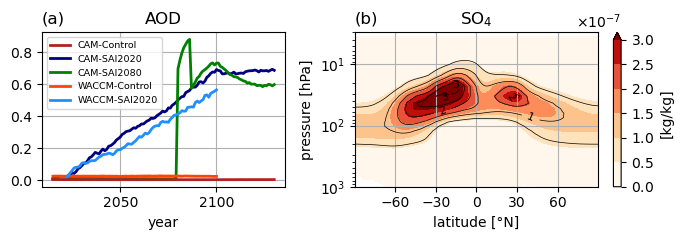

In [4]:
fig, ax = plt.subplots(1,2, figsize=(7,2.5), width_ratios=[1,1.25])

# line plot
AODgm['cam.control'].plot(ax=ax[0], c='firebrick', lw=2, label='CAM-Control', zorder=4)
AODgm['cam.SAI2020'].plot(ax=ax[0], c='navy', lw=2, label='CAM-SAI2020')
AODgm['cam.SAI2080'].plot(ax=ax[0], c='green', lw=2, label='CAM-SAI2080')
AODgm['waccm.control'].plot(ax=ax[0], c='orangered', lw=2, label='WACCM-Control')
AODgm['waccm.SAI2020'].plot(ax=ax[0], c='dodgerblue', lw=2, label='WACCM-SAI2020')

# contour
p2a = SO4zm['cam.SAI2020.plev34.f'].plot.contourf(ax=ax[1], yscale='log', yincrease=False, y='plev34', cmap='OrRd', vmin=0, levels=np.arange(0,3.1e-7,0.5e-7))
p2b = SO4zm['waccm.SAI2020.plev34.f'].plot.contour(ax=ax[1], yscale='log', yincrease=False, y='plev34', colors='k', linewidths=0.5, vmin=0, levels=np.arange(0,3.1e-7,0.5e-7))
plt.clabel(p2b, levels=p2b.levels[0::2], inline=True, fontsize=8)
ax[0].legend(loc='upper left', prop={'size':6.9})
ax[0].set_xlabel('year')
ax[0].set_ylabel('')
ax[0].set_title(r'AOD'); ax[0].set_title('(a)', loc='left')
ax[0].grid()
ax[1].set_ylim([1000,3])
ax[1].set_ylabel('pressure [hPa]')
ax[1].set_xlabel('latitude [°N]')
ax[1].set_xticks(range(-60,61,30))
ax[1].grid()
ax[1].set_title(r'SO$_4$'); ax[1].set_title('(b)', loc='left')

cbax = p2a.colorbar.ax
cbax.set_ylabel(f"[kg/kg]")
cbax.ticklabel_format(useMathText=True)

plt.tight_layout()
fig.savefig('figures/aod_so4mass.pdf')

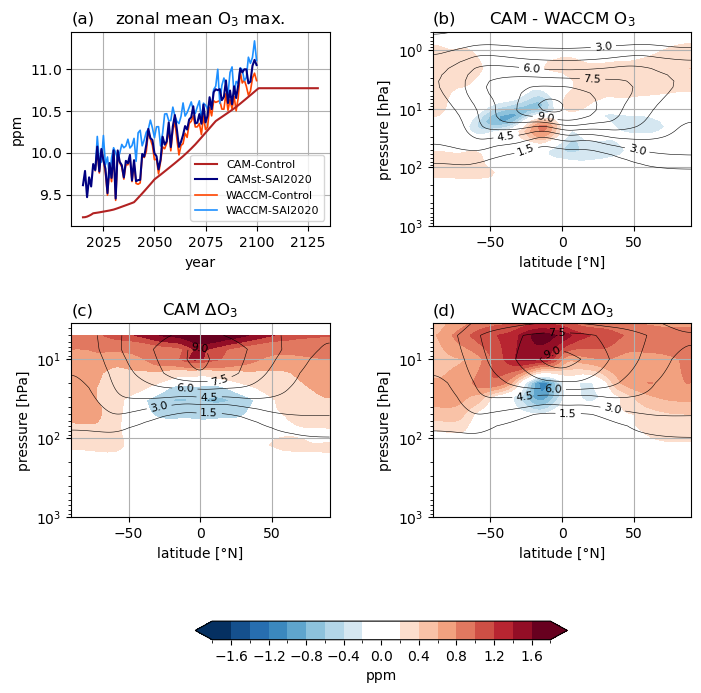

In [3]:
fig, axs = plt.subplots(2,2, figsize=(8,9))
Olevels = np.linspace(0,1.05e-5,8)
dlevels = np.linspace(-18e-7,18e-7,19)

# colormap SAI2020 - REF
yoink = mpl.colormaps['RdBu_r']#.resampled(len(dlevels))
newcolors = yoink(np.linspace(0,1,len(dlevels)-1))
white = np.array([1, 1, 1, 1])
newcolors[8:10,:] = white
newcmap = colors.ListedColormap(newcolors)

# # colormap CAM - WACCM
# yoink = mpl.colormaps['PuOr_r'].resampled(16)
# newcolors = yoink(np.linspace(0,1,16))
# white = np.array([1, 1, 1, 1])
# newcolors[7:9,:] = white
# newcmap2 = colors.ListedColormap(newcolors)

for ax in axs.flatten():
    ax.grid(which='major')
    
# CAM
(O3zm['cam.control.plev34.gm']/1e-6).plot(ax=axs[0,0], lw=1.5, label='CAM-Control', c='firebrick', zorder=4, markersize=4)
#O3zm['cam.SAI2020.plev34.gm'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2020', c='navy', linestyle='-', marker=2)
#O3zm['cam.SAI2080.plev34.gm'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2080', c='green',linestyle='-', marker=3)
(O3zm['camstrat.SAI2020.plev34.gm']/1e-6).plot(ax=axs[0,0], lw=1.5, label='CAMst-SAI2020', c='navy', zorder=4)

# WACCM
(O3zm['waccm.control.plev19.gm']/1e-6).plot(ax=axs[0,0], lw=1.2, label='WACCM-Control', c='orangered')
(O3zm['waccm.SAI2020.plev19.gm']/1e-6).plot(ax=axs[0,0], lw=1.2, label='WACCM-SAI2020', c='dodgerblue')


# zonal mean O3
pkwargs = dict(yscale='log', yincrease=False, add_colorbar=False)
p01 = ((O3zm['camstrat.SAI2020.plev70.f']-O3zm['waccm.SAI2020.plev70.f'])/1e-6).plot.contourf(ax=axs[0,1], y='plev70', ylim=[1000,0.5], levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c01 = ((O3zm['waccm.SAI2020.plev70.f'])/1e-6).plot.contour(ax=axs[0,1], y='plev70', ylim=[1000,0.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
p10 = ((O3zm['camstrat.SAI2020.plev34.f']-O3zm['cam.control.plev34.i'])/1e-6).plot.contourf(ax=axs[1,0], y='plev34', ylim=[1000,3.5], levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c10 = (O3zm['cam.control.plev34.i']/1e-6).plot.contour(ax=axs[1,0], y='plev34', ylim=[1000,3.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
p11 = ((O3zm['waccm.SAI2020.plev19.f']-O3zm['waccm.control.plev19.i'])/1e-6).plot.contourf(ax=axs[1,1], y='plev19', ylim=[1000,3.5], extend='both', levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c11 = (O3zm['waccm.control.plev19.i']/1e-6).plot.contour(ax=axs[1,1], y='plev19', ylim=[1000,3.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
axs[0,1].clabel(c01, fontsize=8)
axs[1,0].clabel(c10, fontsize=8)
axs[1,1].clabel(c11, fontsize=8)
axs[0,0].set_title(r'zonal mean O$_3$ max.'); axs[0,0].set_title('(a)', loc='left')
axs[0,1].set_title(r'CAM - WACCM O$_3$'); axs[0,1].set_title('(b)', loc='left')
axs[1,0].set_title(r'CAM $\Delta$O$_3$'); axs[1,0].set_title('(c)', loc='left')
axs[1,1].set_title(r'WACCM $\Delta$O$_3$'); axs[1,1].set_title('(d)', loc='left')
axs[0,1].set_xlabel('latitude [°N]')
axs[1,0].set_xlabel('latitude [°N]')
axs[1,1].set_xlabel('latitude [°N]')
axs[0,0].set_ylabel('ppm')
axs[0,1].set_ylabel('pressure [hPa]')
axs[1,0].set_ylabel('pressure [hPa]')
axs[1,1].set_ylabel('pressure [hPa]')
axs[0,0].ticklabel_format(axis='y', useMathText=True)

axs[0,0].legend(prop={'size':8})
#fig.delaxes(axs[0,1])
plt.subplots_adjust(wspace=0.4, hspace=0.5)

cb = fig.colorbar(p11, ax=axs[:,:], shrink=0.6, orientation='horizontal')
cb.ax.set_xlabel('ppm')
cb.ax.ticklabel_format(axis='x', useMathText=True)


#plt.tight_layout()
fig.savefig('figures/ozone.pdf')

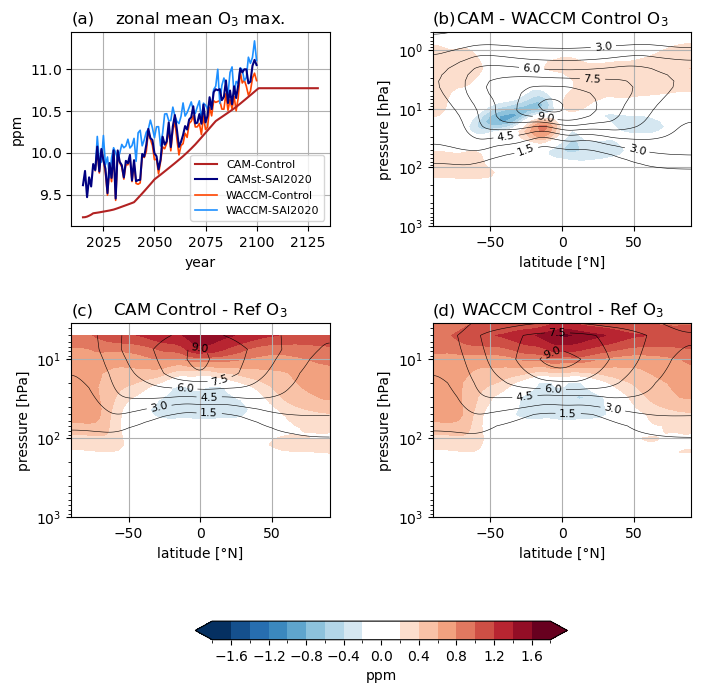

In [7]:
fig, axs = plt.subplots(2,2, figsize=(8,9))
Olevels = np.linspace(0,1.05e-5,8)
dlevels = np.linspace(-18e-7,18e-7,19)

# colormap SAI2020 - REF
yoink = mpl.colormaps['RdBu_r']#.resampled(len(dlevels))
newcolors = yoink(np.linspace(0,1,len(dlevels)-1))
white = np.array([1, 1, 1, 1])
newcolors[8:10,:] = white
newcmap = colors.ListedColormap(newcolors)

# # colormap CAM - WACCM
# yoink = mpl.colormaps['PuOr_r'].resampled(16)
# newcolors = yoink(np.linspace(0,1,16))
# white = np.array([1, 1, 1, 1])
# newcolors[7:9,:] = white
# newcmap2 = colors.ListedColormap(newcolors)

for ax in axs.flatten():
    ax.grid(which='major')
    
# CAM
(O3zm['cam.control.plev34.gm']/1e-6).plot(ax=axs[0,0], lw=1.5, label='CAM-Control', c='firebrick', zorder=4, markersize=4)
#O3zm['cam.SAI2020.plev34.gm'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2020', c='navy', linestyle='-', marker=2)
#O3zm['cam.SAI2080.plev34.gm'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2080', c='green',linestyle='-', marker=3)
(O3zm['camstrat.SAI2020.plev34.gm']/1e-6).plot(ax=axs[0,0], lw=1.5, label='CAMst-SAI2020', c='navy', zorder=4)

# WACCM
(O3zm['waccm.control.plev19.gm']/1e-6).plot(ax=axs[0,0], lw=1.2, label='WACCM-Control', c='orangered')
(O3zm['waccm.SAI2020.plev19.gm']/1e-6).plot(ax=axs[0,0], lw=1.2, label='WACCM-SAI2020', c='dodgerblue')


# zonal mean O3
pkwargs = dict(yscale='log', yincrease=False, add_colorbar=False)
p01 = ((O3zm['camstrat.SAI2020.plev70.f']-O3zm['waccm.SAI2020.plev70.f'])/1e-6).plot.contourf(ax=axs[0,1], y='plev70', ylim=[1000,0.5], levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c01 = ((O3zm['waccm.SAI2020.plev70.f'])/1e-6).plot.contour(ax=axs[0,1], y='plev70', ylim=[1000,0.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
p10 = ((O3zm['cam.control.plev34.f']-O3zm['cam.control.plev34.i'])/1e-6).plot.contourf(ax=axs[1,0], y='plev34', ylim=[1000,3.5], levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c10 = (O3zm['cam.control.plev34.i']/1e-6).plot.contour(ax=axs[1,0], y='plev34', ylim=[1000,3.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
p11 = ((O3zm['waccm.control.plev19.f']-O3zm['waccm.control.plev19.i'])/1e-6).plot.contourf(ax=axs[1,1], y='plev19', ylim=[1000,3.5], extend='both', levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c11 = (O3zm['waccm.control.plev19.i']/1e-6).plot.contour(ax=axs[1,1], y='plev19', ylim=[1000,3.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
axs[0,1].clabel(c01, fontsize=8)
axs[1,0].clabel(c10, fontsize=8)
axs[1,1].clabel(c11, fontsize=8)
axs[0,0].set_title(r'zonal mean O$_3$ max.'); axs[0,0].set_title('(a)', loc='left')
axs[0,1].set_title(r'CAM - WACCM Control O$_3$'); axs[0,1].set_title('(b)', loc='left')
axs[1,0].set_title(r'CAM Control - Ref O$_3$'); axs[1,0].set_title('(c)', loc='left')
axs[1,1].set_title(r'WACCM Control - Ref O$_3$'); axs[1,1].set_title('(d)', loc='left')
axs[0,1].set_xlabel('latitude [°N]')
axs[1,0].set_xlabel('latitude [°N]')
axs[1,1].set_xlabel('latitude [°N]')
axs[0,0].set_ylabel('ppm')
axs[0,1].set_ylabel('pressure [hPa]')
axs[1,0].set_ylabel('pressure [hPa]')
axs[1,1].set_ylabel('pressure [hPa]')
axs[0,0].ticklabel_format(axis='y', useMathText=True)

axs[0,0].legend(prop={'size':8})
#fig.delaxes(axs[0,1])
plt.subplots_adjust(wspace=0.4, hspace=0.5)

cb = fig.colorbar(p11, ax=axs[:,:], shrink=0.6, orientation='horizontal')
cb.ax.set_xlabel('ppm')
cb.ax.ticklabel_format(axis='x', useMathText=True)


#plt.tight_layout()
#fig.savefig('figures/ozone.pdf')

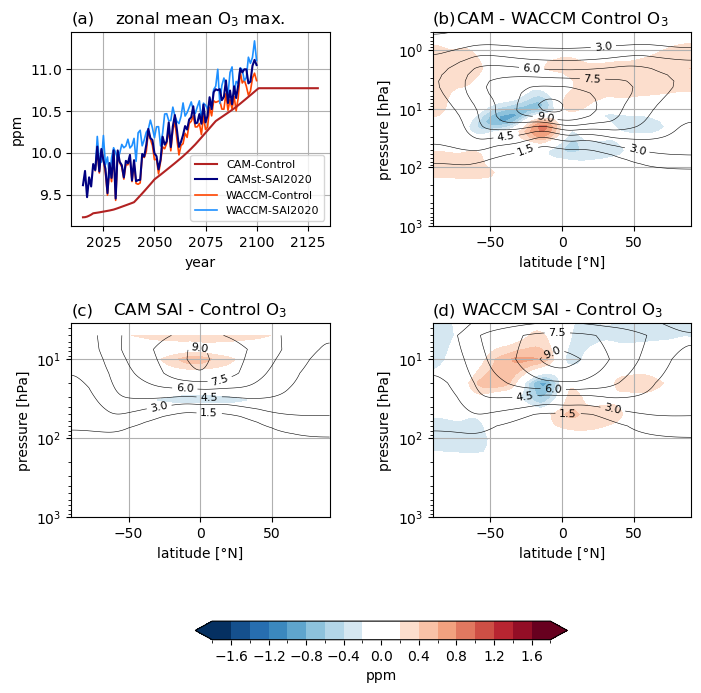

In [8]:
fig, axs = plt.subplots(2,2, figsize=(8,9))
Olevels = np.linspace(0,1.05e-5,8)
dlevels = np.linspace(-18e-7,18e-7,19)

# colormap SAI2020 - REF
yoink = mpl.colormaps['RdBu_r']#.resampled(len(dlevels))
newcolors = yoink(np.linspace(0,1,len(dlevels)-1))
white = np.array([1, 1, 1, 1])
newcolors[8:10,:] = white
newcmap = colors.ListedColormap(newcolors)

# # colormap CAM - WACCM
# yoink = mpl.colormaps['PuOr_r'].resampled(16)
# newcolors = yoink(np.linspace(0,1,16))
# white = np.array([1, 1, 1, 1])
# newcolors[7:9,:] = white
# newcmap2 = colors.ListedColormap(newcolors)

for ax in axs.flatten():
    ax.grid(which='major')
    
# CAM
(O3zm['cam.control.plev34.gm']/1e-6).plot(ax=axs[0,0], lw=1.5, label='CAM-Control', c='firebrick', zorder=4, markersize=4)
#O3zm['cam.SAI2020.plev34.gm'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2020', c='navy', linestyle='-', marker=2)
#O3zm['cam.SAI2080.plev34.gm'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2080', c='green',linestyle='-', marker=3)
(O3zm['camstrat.SAI2020.plev34.gm']/1e-6).plot(ax=axs[0,0], lw=1.5, label='CAMst-SAI2020', c='navy', zorder=4)

# WACCM
(O3zm['waccm.control.plev19.gm']/1e-6).plot(ax=axs[0,0], lw=1.2, label='WACCM-Control', c='orangered')
(O3zm['waccm.SAI2020.plev19.gm']/1e-6).plot(ax=axs[0,0], lw=1.2, label='WACCM-SAI2020', c='dodgerblue')


# zonal mean O3
pkwargs = dict(yscale='log', yincrease=False, add_colorbar=False)
p01 = ((O3zm['camstrat.SAI2020.plev70.f']-O3zm['waccm.SAI2020.plev70.f'])/1e-6).plot.contourf(ax=axs[0,1], y='plev70', ylim=[1000,0.5], levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c01 = ((O3zm['waccm.SAI2020.plev70.f'])/1e-6).plot.contour(ax=axs[0,1], y='plev70', ylim=[1000,0.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
p10 = ((O3zm['camstrat.SAI2020.plev34.f']-O3zm['cam.control.plev34.f'])/1e-6).plot.contourf(ax=axs[1,0], y='plev34', ylim=[1000,3.5], levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c10 = (O3zm['cam.control.plev34.i']/1e-6).plot.contour(ax=axs[1,0], y='plev34', ylim=[1000,3.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
p11 = ((O3zm['waccm.SAI2020.plev19.f']-O3zm['waccm.control.plev19.f'])/1e-6).plot.contourf(ax=axs[1,1], y='plev19', ylim=[1000,3.5], extend='both', levels=dlevels/1e-6, cmap=newcmap, **pkwargs)
c11 = (O3zm['waccm.control.plev19.i']/1e-6).plot.contour(ax=axs[1,1], y='plev19', ylim=[1000,3.5], levels=Olevels/1e-6, colors='k', linewidths=0.4, **pkwargs)
axs[0,1].clabel(c01, fontsize=8)
axs[1,0].clabel(c10, fontsize=8)
axs[1,1].clabel(c11, fontsize=8)
axs[0,0].set_title(r'zonal mean O$_3$ max.'); axs[0,0].set_title('(a)', loc='left')
axs[0,1].set_title(r'CAM - WACCM Control O$_3$'); axs[0,1].set_title('(b)', loc='left')
axs[1,0].set_title(r'CAM SAI - Control O$_3$'); axs[1,0].set_title('(c)', loc='left')
axs[1,1].set_title(r'WACCM SAI - Control O$_3$'); axs[1,1].set_title('(d)', loc='left')
axs[0,1].set_xlabel('latitude [°N]')
axs[1,0].set_xlabel('latitude [°N]')
axs[1,1].set_xlabel('latitude [°N]')
axs[0,0].set_ylabel('ppm')
axs[0,1].set_ylabel('pressure [hPa]')
axs[1,0].set_ylabel('pressure [hPa]')
axs[1,1].set_ylabel('pressure [hPa]')
axs[0,0].ticklabel_format(axis='y', useMathText=True)

axs[0,0].legend(prop={'size':8})
#fig.delaxes(axs[0,1])
plt.subplots_adjust(wspace=0.4, hspace=0.5)

cb = fig.colorbar(p11, ax=axs[:,:], shrink=0.6, orientation='horizontal')
cb.ax.set_xlabel('ppm')
cb.ax.ticklabel_format(axis='x', useMathText=True)


#plt.tight_layout()
#fig.savefig('figures/ozone.pdf')

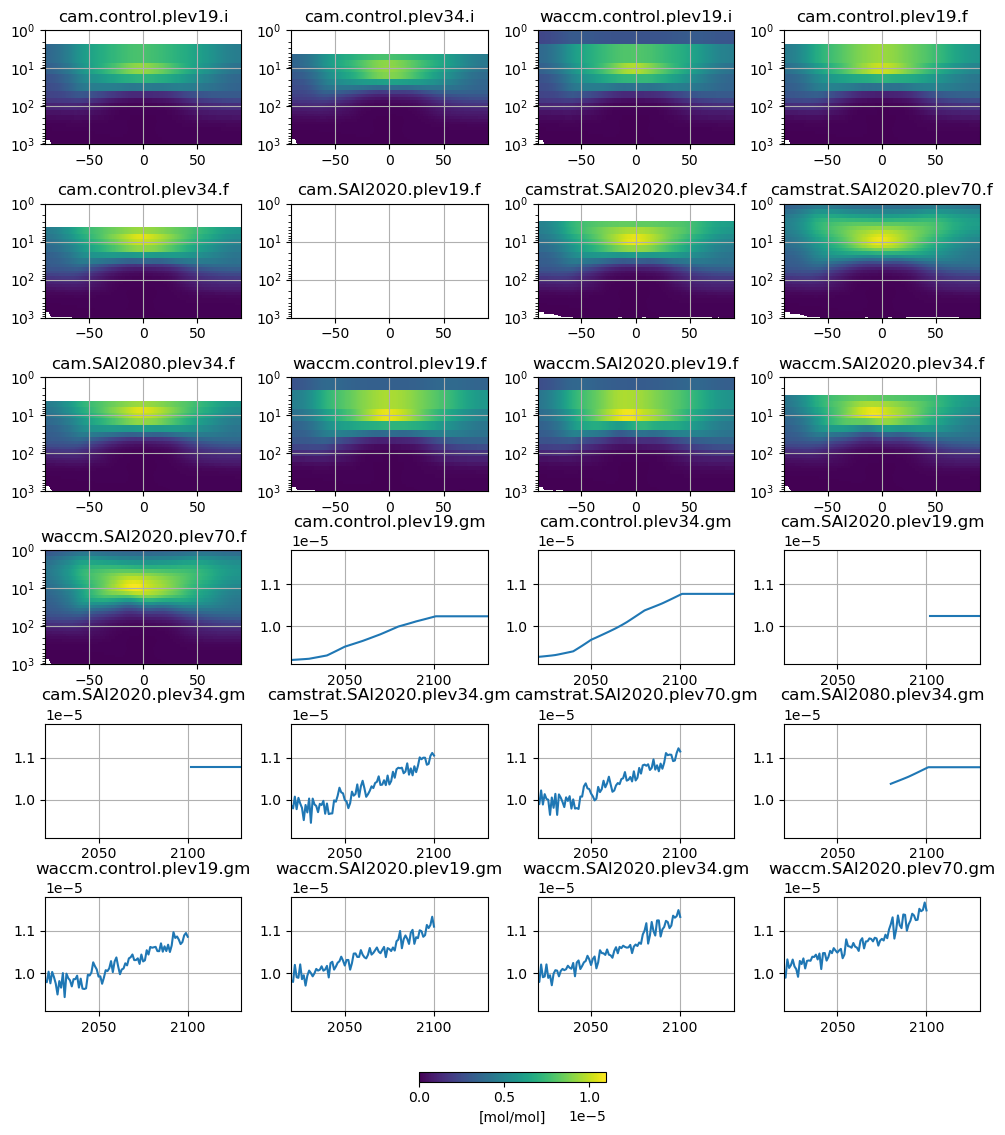

In [8]:
fig, axs = plt.subplots(6,4, figsize=(10,13))
for ax,exp in zip(axs.flatten(),O3zm):
    try:
        p = O3zm[exp].plot(ax=ax, x='lat', yincrease=False, yscale='log', vmin=0, vmax=1.1e-5, ylim=[1000,1], add_colorbar=False)
    except:
        O3zm[exp].plot(ax=ax, x='year', xlim=[2020,2130], ylim=[0.91e-5,1.18e-5])
    ax.grid()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(exp)
plt.tight_layout()
fig.colorbar(p, ax=axs[:,:], orientation='horizontal', shrink=0.2, pad=0.05, label='[mol/mol]')
#axs[1,1].set_title('')
